In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Loading data

### Scan-o-matic data

In [2]:
data = np.load("curves_raw.npy")
data.shape  # Expecting four 32 x 48 plates

(4, 32, 48, 218)

### Pre-computed $\alpha$

In [3]:
precomputed_alphas = np.load("alpha/computed-diffusion.npy")
## Taking only inner 32 x 48 matrix in case colony-free borders are present
precomputed_alphas = precomputed_alphas[:, 3:-3, 3:-3, :]
precomputed_alphas.shape

(4, 32, 48, 208)

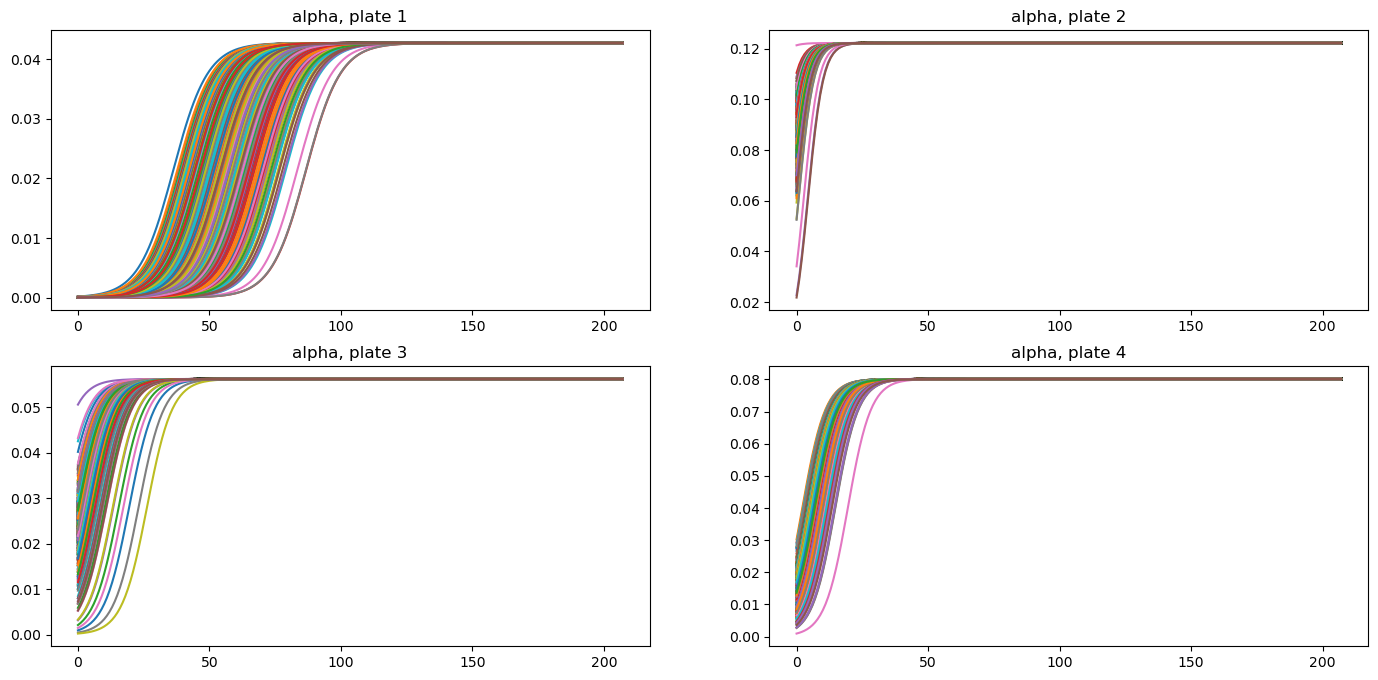

In [4]:
## Plot assumes 4 plates
plt.subplots(2, 2, figsize=(17, 8))
for plate_n in range(4):
    plt.subplot(2, 2, plate_n+1)
    for i in range(precomputed_alphas.shape[1]):
        for j in range(precomputed_alphas.shape[2]):
            plt.plot(precomputed_alphas[plate_n, i, j, :])
    plt.title("alpha, plate " + str(plate_n + 1))

### Plate-specific parameters

In [5]:
plate_parameters = pd.read_csv("diffusion-parameters/coptimal_iterative.csv")  # Assuming column order: D, nu_1, K, kappa, nu_2
plate_parameters

,D,nu1,K,kappa,nu2
0,0.086200,0.000002,5.771290,0.114922,1.265080e-08
1,0.095556,0.000011,17.924599,0.007107,6.468763e-08
2,0.103093,0.000008,14.129226,0.007543,1.641677e-07
3,0.127408,0.000006,6.962409,0.028304,4.076121e-08


# Simulation

In [6]:
n_plates = 4      # Number of simulated plates (4 by default to fit the Scan-o-matic data)
o_r = 32          # Number of rows of the plate grid
o_c = 48          # Number of columns on the plate grid
o_t = 208         # Original (desired) number of time points, should be the same as in alphas
aw = 3            # Additional rows/columns of wells on the borders

max_time = 208    # Maximum time to simulate until. The number of time points will be int(max_time/dt)
dt = 0.1          # Discrete time step

s0 = 1            # Initial nutrient concentration

nrows = o_r+aw*2  # Number of simulated plate rows with additional wells taken into account
ncols = o_c+aw*2  # Ditto for columns

n_all_plates = np.zeros((n_plates, o_t, o_r, o_c))
s_all_plates = np.zeros((n_plates, o_t, o_r, o_c))
sh_all_plates = np.zeros((n_plates, o_t, o_r, o_c))
a_all_plates = np.zeros((n_plates, o_t, o_r, o_c))

for plate_n in range(n_plates):
    D, nu1, K, Kappa, nu2 = plate_parameters.iloc[plate_n]
    N0 = data[plate_n, :, :, 0]  # Initial population sizes taken from Scan-o-matic data

    s = np.zeros((nrows, ncols))
    s[:, :] = s0

    n = np.zeros((nrows, ncols))
    n[aw:n.shape[0]-aw, aw:n.shape[1]-aw] = N0

    a = precomputed_alphas[plate_n].transpose(2, 0, 1)

    ## Alpha extrapolation to fit the number of simulated time steps
    ex_alphas = np.full((int(max_time/dt), o_r, o_c), np.nan)
    ex_ts = int(ex_alphas.shape[0]/a.shape[0])
    for i in range(o_r):
        for j in range(o_c):
            for t in range(o_t):
                ex_alphas[t*ex_ts, i, j] = a[t, i, j]
            ex_alphas[:, i, j] = pd.DataFrame(ex_alphas[:, i, j]).interpolate().to_numpy().reshape(-1,)

    ex_a = np.zeros((ex_alphas.shape[0], nrows, ncols))
    ex_a[:, aw:nrows-aw, aw:ncols-aw] = ex_alphas

    n_curves = np.array([])
    s_curves = np.array([])
    sh_curves = np.array([])
    t = 0   # Simulated time
    ti = 0  # Time point index
    while t < max_time-dt:
        n_curves = np.append(n_curves, n[aw:nrows-aw, aw:ncols-aw])
        s_curves = np.append(s_curves, s[aw:nrows-aw, aw:ncols-aw])
        
        shat = np.zeros(s.shape)
        
        ## Mean nutrient field at corner colonies
        shat[0, 0] = (s[0, 1] + s[1, 0] + s[1, 1])/3
        shat[0, -1] = (s[0, -2] + s[1, -1] + s[1, -2])/3
        shat[-1, 0] = (s[-2, 0] + s[-2, 1] + s[-1, 1])/3
        shat[-1, -1] = (s[-1, -2] + s[-2, -2] + s[-2, -1])/3

        ## Mean nutrient field at boundary colonies, left/right
        for i in range(1, nrows-1):
            shat[i, 0] = (s[i-1, 0] + s[i-1, 1] + s[i, 1] + s[i+1, 1] + s[i+1, 0])/5
            shat[i, -1] = (s[i-1, -1] + s[i-1, -2] + s[i, -2] + s[i+1, -2] + s[i+1, -1])/5

        ## Mean nutrient field at boundary colonies, top/bottom
        for j in range(1, ncols-1):
            shat[0, j] = (s[0, j-1] + s[1, j-1] + s[1, j] + s[1, j+1] + s[0, j+1])/5
            shat[-1, j] = (s[-1, j-1] + s[-2, j-1] + s[-2, j] + s[-2, j+1] + s[-1, j+1])/5     

        ## Mean nutrient field at non-boundary (inner) colonies
        for i in range(1, nrows-1):
            for j in range(1, ncols-1):
                shat[i, j] = (s[i-1, j-1] + s[i-1, j] + s[i-1, j+1] + s[i, j-1] + s[i, j+1] + s[i+1, j-1] + s[i+1, j] + s[i+1, j+1])/8

        sh_curves = np.append(sh_curves, shat[aw:nrows-aw, aw:ncols-aw])
        
        ## The two main differential equations
        dndt = ex_a[ti]*n*(1 + np.exp(-s*K))**(-Kappa)  # Change in population size
        dsdt = D*(shat - s) - nu1*dndt - nu2*n          # Change in nutrient concentration
        
        n += dndt*dt
        s += dsdt*dt
        t += dt
        ti += 1
    
    n_curves = n_curves.reshape(ti, o_r, o_c)
    s_curves = s_curves.reshape(ti, o_r, o_c)
    sh_curves = sh_curves.reshape(ti, o_r, o_c)
    ex_a_inner = ex_a[:, aw:nrows-aw, aw:ncols-aw]
    
    ## Sub-sampling the time points to fit the original number of time points

    n_all_plates[plate_n] = n_curves[::int(n_curves.shape[0]/o_t), :, :]
    s_all_plates[plate_n] = s_curves[::int(s_curves.shape[0]/o_t), :, :]
    sh_all_plates[plate_n] = sh_curves[::int(sh_curves.shape[0]/o_t), :, :]
    a_all_plates[plate_n] = ex_a_inner[::int(ex_a_inner.shape[0]/o_t), :, :]

t_vec = np.arange(0, max_time, dt)[::int(n_curves.shape[0]/o_t)]

/run/nvme/job_18863917/tmp/ipykernel_803815/207969321.py:79: RuntimeWarning: overflow encountered in exp
  dndt = ex_a[ti]*n*(1 + np.exp(-s*K))**(-Kappa)  # Change in population size


## Plotting results

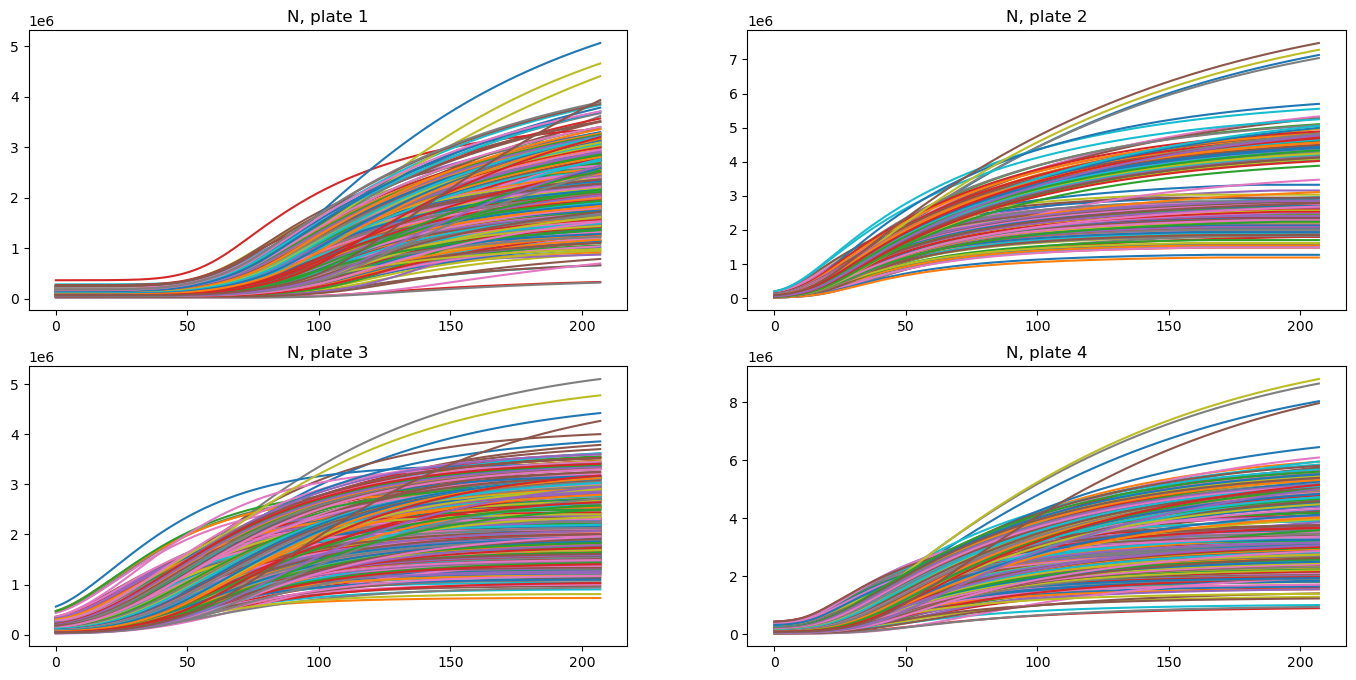

In [7]:
temp = np.swapaxes(np.swapaxes(n_all_plates, 2, 1), 3, 2)

plt.subplots(2, 2, figsize=(17, 8))
for plate_n in range(4):
    plt.subplot(2, 2, plate_n+1)
    for i in range(o_r):
        for j in range(o_c):
            plt.plot(temp[plate_n, i, j, :])
    plt.title("N, plate " + str(plate_n + 1))

## Saving results

In [8]:
path = "./simulation-results/"

### npy format

In [9]:
np.save(path + "n_curves_all_plates_iterative.npy", n_all_plates)
np.save(path + "s_curves_all_plates_iterative.npy", s_all_plates)
np.save(path + "sh_curves_all_plates_iterative.npy", sh_all_plates)
np.save(path + "a_curves_all_plates_iterative.npy", a_all_plates)
np.save(path + "t_vec.npy", t_vec)

In [ ]:
np.save("synthetic-data.npy", n_all_plates)

### Text/dataframe format

In [10]:
empty_df = pd.DataFrame({"plate": np.nan, "row": np.nan, "column": np.nan}, index=[0])
for i in range(o_t):
    empty_df[str(i)] = [np.nan]
    empty_df = empty_df.copy()

df = empty_df.copy()
row_df = empty_df.copy()
    
for p in range(4):
    for i in range(o_r):
        for j in range(o_c):
            row_df.iloc[0] = [int(p), int(i), int(j)] + list(n_all_plates[p, :, i, j])
            df = pd.concat([df, row_df])
df = df.iloc[1:, :]
df.to_csv(path + "n_curves.txt", sep=" ", index=False)
pd.Series(t_vec).to_csv(path + "t_vec.txt", index=False, header=False)
df

,plate,row,column,0,1,2,3,4,5,6,...,198,199,200,201,202,203,204,205,206,207
0,0.0,0.0,0.0,122705.342189,122705.412029,122705.493357,122705.588062,122705.698345,122705.826770,122705.976319,...,3.053008e+06,3.077842e+06,3.102540e+06,3.127100e+06,3.151522e+06,3.175807e+06,3.199955e+06,3.223965e+06,3.247837e+06,3.271571e+06
0,0.0,0.0,1.0,120383.596805,120383.698358,120383.816616,120383.954326,120384.114688,120384.301428,120384.518885,...,2.330432e+06,2.344980e+06,2.359412e+06,2.373730e+06,2.387933e+06,2.402023e+06,2.416000e+06,2.429865e+06,2.443619e+06,2.457261e+06
0,0.0,0.0,2.0,121873.968077,121874.266262,121874.613495,121875.017843,121875.488698,121876.037001,121876.675489,...,2.399288e+06,2.411735e+06,2.424065e+06,2.436279e+06,2.448379e+06,2.460364e+06,2.472237e+06,2.483998e+06,2.495648e+06,2.507188e+06
0,0.0,0.0,3.0,112203.773908,112204.193939,112204.683057,112205.252627,112205.915877,112206.688216,112207.587583,...,2.278626e+06,2.289686e+06,2.300635e+06,2.311474e+06,2.322203e+06,2.332823e+06,2.343337e+06,2.353744e+06,2.364045e+06,2.374242e+06
0,0.0,0.0,4.0,119501.155083,119501.784506,119502.517456,119503.370956,119504.364833,119505.522169,119506.869845,...,2.471065e+06,2.482381e+06,2.493578e+06,2.504657e+06,2.515619e+06,2.526465e+06,2.537196e+06,2.547814e+06,2.558320e+06,2.568713e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,3.0,31.0,43.0,81436.461829,82584.639509,83986.097864,85687.057014,87738.392397,90194.884713,93114.178768,...,4.908077e+06,4.915668e+06,4.923149e+06,4.930523e+06,4.937790e+06,4.944951e+06,4.952009e+06,4.958965e+06,4.965820e+06,4.972575e+06
0,3.0,31.0,44.0,68648.023818,69676.011316,70928.593051,72445.872056,74271.687464,76452.900252,79038.457990,...,4.930432e+06,4.938702e+06,4.946857e+06,4.954899e+06,4.962830e+06,4.970650e+06,4.978362e+06,4.985967e+06,4.993466e+06,5.000860e+06
0,3.0,31.0,45.0,84009.518481,84428.718813,84949.931600,85596.397982,86395.855505,87381.031178,88590.020414,...,5.065872e+06,5.075461e+06,5.084926e+06,5.094266e+06,5.103484e+06,5.112581e+06,5.121558e+06,5.130417e+06,5.139159e+06,5.147786e+06
0,3.0,31.0,46.0,56632.316102,56901.784552,57236.989393,57652.990395,58167.801853,58802.736157,59582.680797,...,4.898587e+06,4.910027e+06,4.921329e+06,4.932495e+06,4.943524e+06,4.954420e+06,4.965183e+06,4.975815e+06,4.986316e+06,4.996690e+06
